## **Look at `./processing.ipynb` first**

In [1]:
# imports
import sys
# Need to do this so we can import the modules in `../libs`
sys.path.insert(0, '../')
import os, tqdm, json, re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# custom libraries
import libs.analysis as analysis
import libs.utils as utils
import libs.export as export
import libs.generate as generate

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Load the segments created in `./processing.ipynb`

In [2]:
sources = [
    "all_users",
    "desktop_tablet_users",
    "mobile_users",
]
data = {}
for source in sources:
    data[source] = utils.load_bq_df(f"./data/segmented/{source}.csv", False)

for d in data:
    utils.print_success(f"Loaded: {d}")

Loaded: all_users
Loaded: desktop_tablet_users
Loaded: mobile_users


In [3]:
utils.status(data["all_users"])

Shape: (2, 4)


,segment,optimisation_variant,impressions,purchases
0,All Users,Control,3068,139
1,All Users,Variation 1,5159,122


Segment DataFrames are stored in a dictionary for easier processing

In [4]:
data.keys()

dict_keys(['all_users', 'desktop_tablet_users', 'mobile_users'])

This BEAST will take your preprocessed dataset and apply test specific processing to it. It'll calculate Bayesian Significance, Relative impact and format the strings 

In [5]:
def generate_calculated_dataset(data, segment = "Missing Segment Name", fields_to_drop = [], METRICS = [], NAME_MAP = []):
    calculated_data = None
    if len(METRICS) > 0:
        processed_data = data.copy()
        # Sort variant names alphabetically and use the first one as the control name
        # in default use cases this will revert to control as C is before V in the alphabet,
        # however when  control doesn't exist, variation_1 will be chosen, assuming all variants
        # have a consistent naming convention like variation_{x}, Variation {x}, etc. 
        control_name = processed_data.optimisation_variant.sort_values().values[0]

        # Re-generate control data
        processed_data.drop([col for col in processed_data.columns if "control" in col], axis=1, inplace=True)
        control_data = processed_data[processed_data.optimisation_variant == control_name].copy()
        control_data.drop("optimisation_variant", axis=1, inplace=True)
        metrics = [metric["name"] for metric in METRICS]
        metrics_renamed = [f"control_{metric}" for metric in metrics]
        control_data.columns = ["segment"] + metrics_renamed
        processed_data = pd.merge(left=processed_data, right=control_data, how="left", on=["segment"])
        # return processed_data
        # Generate the calculated data
        calculated_data = analysis.summarise_test(None, processed_data, metrics=METRICS, control_name = control_name)

        # Format the variant name
        calculated_data.optimisation_variant = calculated_data.optimisation_variant.str.replace("_", " ", regex=True)
        calculated_data.optimisation_variant = calculated_data.optimisation_variant.str.capitalize()
        calculated_data.rename(columns={"optimisation_variant": "Variant"}, inplace=True)

        # Drop it like it's hot
        if len(fields_to_drop) > 0:
            for field in fields_to_drop:
                if field in calculated_data.columns:
                    calculated_data.drop(field, axis=1, inplace=True)
            
        # Add the segment name
        calculated_data["segment"] = segment
        calculated_data["segment"] = calculated_data["segment"].replace("_", " ", regex=True)
        calculated_data["segment"] = calculated_data["segment"].str.capitalize()

        # Set and reset index to shift the ordering around for readibility
        calculated_data.set_index(["segment", "Variant"], inplace=True)
        calculated_data.reset_index(inplace=True)

        if len(NAME_MAP) > 0:
            calculated_data.rename(columns=NAME_MAP, inplace=True)

    return calculated_data

Spit out the columns for reference

In [6]:
data["all_users"].columns

Index(['segment', 'optimisation_variant', 'impressions', 'purchases'], dtype='object')

This is where you specify the metrics in the dataset.

```
analysis.build_metric_object(
    order = "Basically just an ID, not really used tbh."
    name = "The column name in `data`, use above cell as reference"
    display_name = "The name you want it to be called, can be anything"
    previous_step = "Can be None if no previous step. Will use this to calculate progression/conversion rate, uplift and Bayesian significance."
),
```

In [7]:
METRICS = [
    analysis.build_metric_object(0, "impressions", "Impressions", None),
    analysis.build_metric_object(1, "purchases", "Purchases", "impressions"),
]

Sometimes you don't want significance on a column for some reason, this is where you add a string for each column name in the output that you want to remove

In [8]:
fields_to_drop = [ ]

In [9]:
data["all_users"]

,segment,optimisation_variant,impressions,purchases
0,All Users,Control,3068,139
1,All Users,Variation 1,5159,122


Sometimes you want to rename the generated columns in the output, this is where you map them.

In [10]:
NAME_MAP = {
    "segment": "Segment",
}

Magic time!

In [11]:
processed_data = {}
for source in data:
    print(f"Calculating data for {source}")
    processed_data[source] = generate_calculated_dataset(data = data[source], segment=source, fields_to_drop=fields_to_drop, METRICS=METRICS, NAME_MAP = NAME_MAP)
    processed_data[source].fillna(0, inplace=True)

Calculating data for all_users


Calculating data for desktop_tablet_users
Calculating data for mobile_users


Look how *formatted* it is

In [12]:
utils.status(processed_data["all_users"])

Shape: (2, 7)


,Segment,Variant,Impressions,Purchases,Purchases Significance,Purchases Impact,Purchases Rate
0,All users,Control,3068,139,50.000000,0.000000,4.530639
1,All users,Variation 1,5159,122,0.000005,-47.804284,2.364799


Now, we gotta transform it from a `DataFrame` into a dict/JSON so the generate library can spit it out into a `.PPTX` 

In [13]:
# This transforms data into a format for an individual slide.
def generate_slide_data(data, config):
    slide_data = data[config["cols"]].copy()
    segment = slide_data.Segment.values[0]
    print(f"Generated slide data for {segment}")
    slide_data = slide_data.drop("Segment", axis=1)
    slide_data = export.format_series(slide_data, format_map = None, rename_map = config["rename_map"], transpose=False)
    slide_data_formatted = export.format_series(slide_data, format_map = config["format_map"], transpose=True)
    return {
        "segment": segment,
        "raw": slide_data,
        "formatted": slide_data_formatted,
    }

In [14]:
# This generates all the visualisations and tables for each section
# Note: Each metric is an individual section, containing a unique slide for each segment.
# i.e. Purchases section contains individual slides for All users, Desktop Users, Mobile users.
def generate_section_data_and_visualisations(data_dict, config):
    slide_data = {}
    notFirst = False
    for source in data_dict:
        if source not in config["ignore"]:
            # Transform data
            data = data_dict[source]
            slide_data[source] = generate_slide_data(data=data, config=config)
            slide_data[source]["visualisation"] = f"{source}-" + config["visualisation_metric"]

            # Generate visualisation
            visualisation_extra_title = "- " + slide_data[source]["segment"]
            visualisation_metric = config["visualisation_metric"]
            visualisation_max_y = config["ylim"]
            if config["ylim"] == "auto":
                y_vals = slide_data[source]["raw"][visualisation_metric]
                visualisation_max_y = y_vals.max()
                visualisation_max_y = visualisation_max_y * 1.2
            export.visualise(slide_data[source]["raw"], visualisation_metric, slide_data[source]["visualisation"], ylim=visualisation_max_y, extra_title=visualisation_extra_title, hide=notFirst, fmt=config["format"])
            notFirst = True
    return slide_data


I got tired of typing descriptions for each segment in the final deck so type it here and it'll get generated alongside the rest of the data

In [15]:
DIMENSIONS_REFERENCE = {
    "all_users": "All users who saw the test at least once.",
    "desktop_tablet_users": "Desktop and Tablet users who saw the test at least once",
    "mobile_users": "Mobile users who saw the test at least once",
}

In [16]:
# Generates all the slides for a section (metric)
def generate_section_slides(DATA, CONFIG, DIMENSIONS):
    slides = [
        export.generate_title_slide(title=CONFIG["visualisation_metric"], subtitle=CONFIG["metric_type"]),
        export.generate_notes_slide(title=CONFIG["visualisation_metric"], content=CONFIG["notes"]),
    ]
    for source in DATA:
        metric_slide = export.generate_metric_slide(
            title=CONFIG["visualisation_metric"],
            segment = DATA[source]["segment"],
            data=DATA[source]["formatted"],
            image_path="./visualisations/"+DATA[source]["visualisation"]+".png",
            footer=f"Segment definition: " + DIMENSIONS[source],
        )
        slides.append(metric_slide)
    return slides

In [17]:
# Divider slide to divide sections that need dividing into individual sections... divided
def generate_divider_slide(title=""):
    slides = [
        export.generate_divider_slide(title)
    ]
    return slides

In [18]:
# Does what is says on the tin
def generate_report_info_slide(report):
    # fmt = '%A %d %B %Y'
    fmt = '%d %B %Y'
    start = report.start_date.values[0]
    end = report.end_date.values[0]
    start = pd.to_datetime(start).strftime(fmt)
    end = pd.to_datetime(end).strftime(fmt)
    
    print(start, "-", end)
    content = {
        "title": "Device Breakdown",
        "points": report.points.tolist(),
        "start": start,
        "end": end,
    }
    
    return [
        export.generate_report_info_slide(title="Notes", content=content),
    ]

This is where we declare our metric and generate the associated section slides 

Generated slide data for All users
Generated slide data for Desktop tablet users
Generated slide data for Mobile users


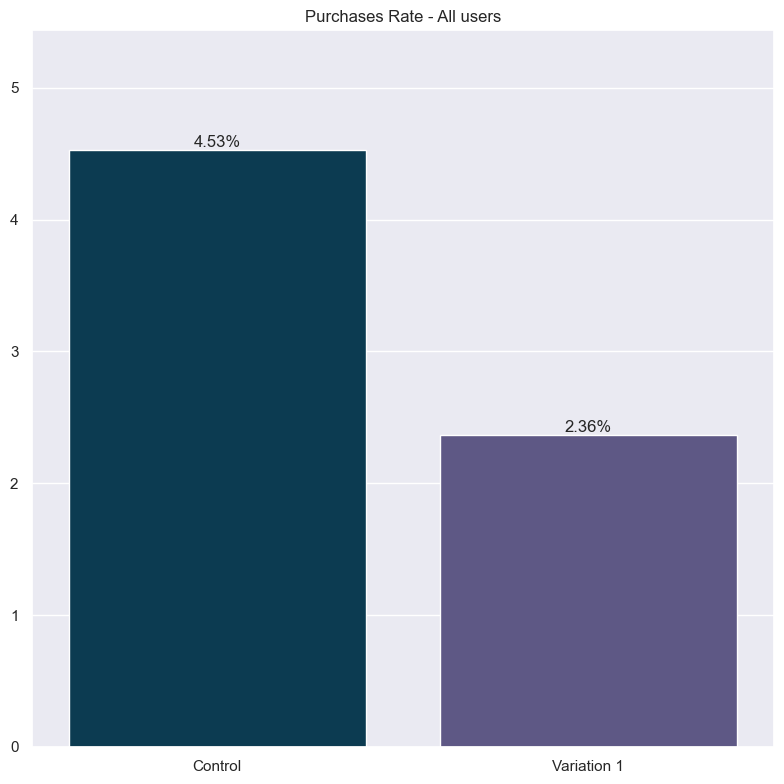

In [19]:
PURCHASES_CONFIG = {
    # Can specify or let it auto generate
    "ylim": "auto",
    # This format is used in the visualisation
    "format": "%.2f%%",
    # Can be anything
    "metric_type": "Primary Metric",
    # The KPI you want in the visualisation
    "visualisation_metric": "Purchases Rate",
    # All the columns you need, Segment is auto removed
    "cols": ["Segment", "Variant", "Impressions", "Purchases", "Purchases Rate", "Purchases Impact", "Purchases Significance"],
    # Apply formatting to specific columns for the table. Most use cases are covered in the `export` library
    "format_map": {
        "Impressions": export.format_int,
        "Purchases": export.format_int,
        "Purchases Rate": export.format_perc,
        "Impact": export.format_perc,
        "Chance of being best": export.format_perc,
    },
    # Rename columns for the table
    "rename_map": {
        "Purchases Impact": "Impact",
        "Purchases Significance": "Chance of being best"
    },
    # Ignore certain segments, just specify a string of the name inthe dictionary 
    "ignore": [  ],
    # Any notes for the first slide of the section, generally used to explain the section but can be replaced with analysis or whatever.
    "notes": [
        'This metric represents the number of purchase events that occur after an Impression.',
        '',
        'This metric is the total number of "purchase" events, which are tracked each time a user completes a transaction.',
        '',
        'An increase in Purchase Rate is a positive result.',
    ]
}
# Take the above and make it into a JSON/dict for the generate library
PURCHASES_DATA = generate_section_data_and_visualisations(processed_data, PURCHASES_CONFIG)
PURCHASES = generate_section_slides(PURCHASES_DATA, PURCHASES_CONFIG, DIMENSIONS_REFERENCE)

In [20]:
utils.status(processed_data["all_users"])

Shape: (2, 7)


,Segment,Variant,Impressions,Purchases,Purchases Significance,Purchases Impact,Purchases Rate
0,All users,Control,3068,139,50.000000,0.000000,4.530639
1,All users,Variation 1,5159,122,0.000005,-47.804284,2.364799


Reformat the device report as bullet points

In [21]:
device_report = utils.load_bq_df("./data/device_report.csv", False)
device_report["points"] = device_report["device_category"].str.capitalize()
device_report.points += " - "
device_report.points += device_report["% of total"].apply(lambda x: f"{x:.2f}%")
device_report.points += device_report["impressions"].apply(lambda x: f" ({x:,.0f} Impressions)")
device_report

,device_category,impressions,% of total,start_date,end_date,points
0,desktop,2256,27.421903,2023-11-20,2023-12-05,"Desktop - 27.42% (2,256 Impressions)"
1,mobile,2869,34.872979,2023-11-20,2023-12-05,"Mobile - 34.87% (2,869 Impressions)"
2,tablet,3102,37.705117,2023-11-20,2023-12-05,"Tablet - 37.71% (3,102 Impressions)"


Turn it into a slide

In [22]:
REPORT_INFO = generate_report_info_slide(device_report)
REPORT_INFO

20 November 2023 - 05 December 2023


[{'name': 'Notes',
  'type': 'Report Info Slide',
  'layout': 'Long Form Messaging 1',
  'title': 'Notes',
  'content': {'title': 'Device Breakdown',
   'points': ['Desktop - 27.42% (2,256 Impressions)',
    'Mobile - 34.87% (2,869 Impressions)',
    'Tablet - 37.71% (3,102 Impressions)'],
   'start': '20 November 2023',
   'end': '05 December 2023'}}]

Bring it all together into an array and generate that mofo

In [23]:
SECTIONS = [
    generate_divider_slide("Report Information"),
    REPORT_INFO,
    generate_divider_slide("Primary Metrics"),
    PURCHASES,
]
SLIDES = list(chain.from_iterable(SECTIONS))
export_config = export.output_metric_to_config(slides=SLIDES, id="TEST001")
generate.generate_report(export_config)

Generating Divider Slide 1 slide for Report Information
Generating Long Form Messaging 1 slide for Notes
Generating Divider Slide 1 slide for Primary Metrics
Generating Title Slide 2 slide for Purchases Rate
Generating Long Form Messaging 1 slide for Purchases Rate
Generating Chart and Data slide for Purchases Rate
Generating Chart and Data slide for Purchases Rate
Generating Chart and Data slide for Purchases Rate
Report Generated Successfully
